In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from stockpy.config import ss_nn_args, shared, training
from sklearn.model_selection import train_test_split
import pandas as pd
from stockpy.probabilistic import DeepMarkovModel, GaussianHMM, BayesianNN
from stockpy.neural_network import MLP, LSTM, GRU, BiGRU, BiLSTM
from stockpy.transformer import Transformer
from stockpy.metrics import evaluate
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
import numpy as np
from stockpy.utils import normalize
import random

In [2]:
class StockDataset(torch.utils.data.Dataset):
    def __init__(self, 
                dataframe, 
                sequence_length=0
                ):

        self.dataframe = dataframe

        self.sequence_length = sequence_length

        x = dataframe.values
        self.X = torch.tensor(x).float()


    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
            y = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)
            y = self.X[0:(i + 1), :]
            y = torch.cat((padding, y), 0)

        return x, y

In [3]:
# read CSV file and drop missing values
df = pd.read_csv('../stock/AAPL.csv', parse_dates=True, index_col='Date').dropna(how="any")
# split data into training and test set
X_train, X_test = train_test_split(df, test_size=0.1, shuffle=False)

In [4]:
# example usage
data = X_train  # assuming you have a pandas DataFrame called 'your_pandas_dataframe'
batch_size = 24  # or whatever batch size you want to use
scaler = normalize(data)
data = scaler.fit_transform()
loader = StockDataset(data, sequence_length=120)
loader = DataLoader(loader, batch_size=24)

In [5]:
for x, y in loader:
    print(x.shape, y.shape)
    break

torch.Size([24, 120, 6]) torch.Size([24, 120, 6])


In [6]:
# Model - seq2seq model with loop over decoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
    def forward(self, x):
        # Forward propagate LSTM
        out, hidden = self.lstm(x)
        
        return out, hidden

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, 5)
        
    def forward(self, x, hidden):
        # Forward propagate LSTM
        out, hidden = self.lstm(x, hidden)
        
        # Pass LSTM output through fully connected layer
        out = self.fc(out)
        
        return out, hidden

class LSTMSeq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, sequence_length):
        super(LSTMSeq2Seq, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.sequence_length = sequence_length
        
        # Define encoder and decoder
        self.encoder = Encoder(input_size, hidden_size, num_layers)
        self.decoder = Decoder(input_size, hidden_size, num_layers)
        
    def forward(self, input):
        # Pass input tensor through encoder
        encoder_outputs, hidden = self.encoder(input)
        
        # Initialize input tensor for decoder
        input_t = torch.zeros(input.size(0), self.input_size, dtype=torch.float).unsqueeze(0)
        
        # Initialize output tensor and hidden state tensor for decoder
        output_tensor = torch.zeros(self.sequence_length, input.size(0), self.input_size)
        hidden_states = torch.zeros(self.sequence_length, self.num_layers, input.size(0), self.hidden_size)
        
        # Pass input tensor through decoder at each time step
        for t in range(self.sequence_length):
            output_t, hidden = self.decoder(input_t, hidden)
            output_t = output_t[-1]
            input_t = output_t.unsqueeze(0)
            output_tensor[t] = output_t
            hidden_states[t] = hidden[0]
        
        return output_tensor, hidden_states

In [7]:
# Set the input and output dimensions
input_dim = 5
# Set the hidden dimension
hidden_dim = 32

# Initialize the model
model = LSTMSeq2Seq(input_size=input_dim, 
                    hidden_size=hidden_dim, 
                    num_layers=1, 
                    sequence_length=120
                    )
# model = torch.load('model.pth')
# model.eval()

In [8]:
def train(model, loader, num_epochs, learning_rate=0.001):
    # set up the optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # set the model to training mode
    model.train()

    best_loss = float('inf')
    patience = 0

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        
        # loop over the batches in the DataLoader
        for x, y in loader:
            # zero the gradients
            optimizer.zero_grad()
            output_tensor, _ = model(x)
            loss = criterion(output_tensor.squeeze().transpose(1,0), y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(loader)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {epoch_loss}", end='\r')
            # torch.save(model, 'model.pth')
            
            # if epoch_loss < best_loss:
            #     best_loss = epoch_loss
            #    patience = 0
            # else:
            #     patience += 1
            #     if patience == 10:
            #         print(f"Early stopping at epoch {epoch}.")
            #        break

    return output_tensor

In [9]:
output_tensor = train(model=model, loader=loader, num_epochs=1000, learning_rate=0.001)

RuntimeError: input.size(-1) must be equal to input_size. Expected 5, got 6

In [ ]:
output = output_tensor.squeeze().transpose(0, 1)
output = output[-1].squeeze().detach().numpy()

In [ ]:
target = X_test['Close'].values
target = target[:120]

In [ ]:
output = output * scaler.std() + scaler.mean()

In [ ]:
output = output[:,-1]

/tmp/ipykernel_431/215580158.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


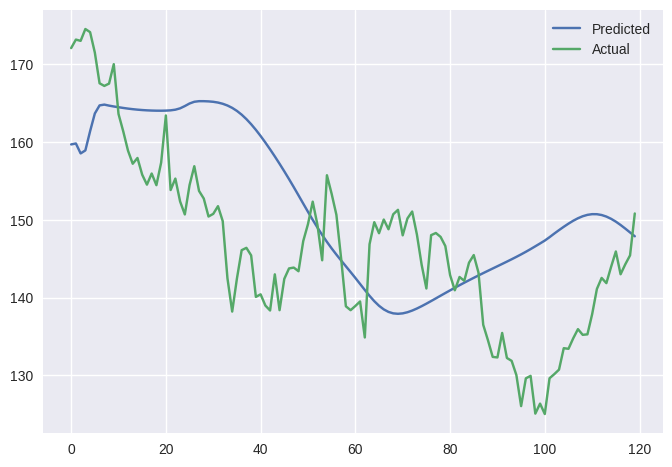

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use('seaborn')
plt.plot(output, label='Predicted')
plt.plot(target, label='Actual')
plt.legend()
plt.savefig('output.png', dpi=300)
plt.show()